# Calour mass-spec analysis demo
## Using data from:
Tripathi, Anupriya, et al.

"Intermittent Hypoxia and Hypercapnia, a Hallmark of Obstructive Sleep Apnea, Alters the Gut Microbiome and Metabolome."

mSystems 3.3 (2018): e00020-18.

The raw LC-MS/MS data used for these analyses is publically available at https://gnps.ucsd.edu/ProteoSAFe/result.jsp?task=56b82a67d9884b0dbda32978281c5ebf&view=advanced_view 

1. The molecules were annotated using GNPS. Link to GNPS job: https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=b412ff7be7d5487ba3a4fd7bd36e07d3)
2. Feature table (Supp. file X1) was generated in MZmine2 using batch mode (Supp. file X2)
3. Mapping file is available at https://github.com/knightlab-analyses/haddad_osa/blob/master/data/haddad_6week_metadata.txt

## set up calour

In [1]:
import calour as ca
ca.set_log_level('INFO')
%matplotlib notebook

## Load MZmine2 feature table, metadata and GnPS file 

We load the mzmine2 table and the corresponding sample metadata file (mapping file).

We also load the gnps cluster info file, which contains gnps ids for metabolites (features) in the table. This is not mandatory but enables interactive analysis of the metabolites in the table.

Each sample is normalized using TSS to 100% (so metabolite frequencies are relative)

sample IDs from the mapping file are cut in the first occurance of ".m", since sample ids in the mapping file are made of the mzmine2 sample ids + ".mzXML"

Calour can read several ms table formats: mzmine2, biom table, gnps exported tsv or generic csv (such as from openMS).
For more information about reading mass-spec data into Calour, see the read_ms documentation [here](http://biocore.github.io/calour/generated/calour.io.read_ms.html#calour.io.read_ms)

In [2]:
exp = ca.read_ms(data_file='data/metabolomics-apnea.mzmine2.csv',
                 sample_metadata_file='data/metabolomics-apnea.sample.txt',
                normalize=100, cut_sample_id_sep='.m',
                gnps_file='data/metabolomics-apnea.gnps.tsv')

2020-08-12 00:37:33 INFO loaded 210 samples, 1099 features
2020-08-12 00:37:33 INFO splitting table sample ids using separator .m. use "data_table_params={'cut_sample_id_sep'=None}" to disable cutting.
2020-08-12 00:37:33 WARNING These have data but do not have metadata: {'row m/z', 'row retention time'}


In [3]:
print(exp)

MS1Experiment metabolomics-apnea.mzmine2.csv with 208 samples, 1099 features


## Reorder the features (metabolites) and samples
Below, we cluster highly correlated metabolites for visualization purposes. Then we sort the samples by 'age' (to visualize trends over time) and then sort by 'exposure_type' (to observe differences between treatment and control samples)

Sorting on equal valus retains the previous order, so samples will be sorted by exposure_type, and within each exposure_type will be sorted by age

In [4]:
expc = exp.cluster_features()
expc = expc.sort_samples(field='age').sort_samples(field='exposure_type')

2019-04-18 14:20:02 INFO After filtering, 1099 remaining


## Plotting the data

<IPython.core.display.Javascript object>


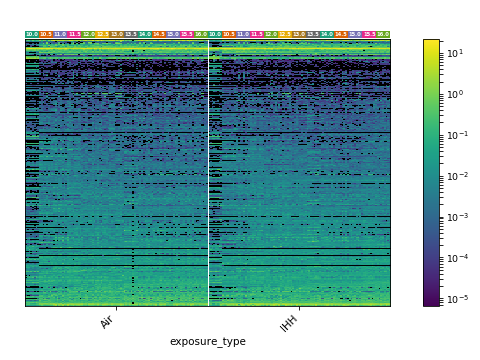

In [5]:
# plotting the modified experiment object
f = expc.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5})

**Observation 1.** We see a stark shift in the molecular composition of gut metabolome between the ages of 10 and 10.5 weeks and the rest of the samples. This is because the samples collected at these ages (10 and 10.5 weeks) were baseline samples collected when mice were given regular chow. After that, the diet was switched to a fat-rich, Western type diet which causes this dramatic shift in the gut metabolome in both, control and treatment group.

## Differentially abundant metabolites between control ('Air') and treatment ('IHH') groups

### Remove the age 10, 10.5 samples since very different from the rest

In [6]:
expcf = expc.filter_samples(field = 'age', values=['10', '10.5'], negate = True)
print(expcf)

MS1Experiment metabolomics-apnea.mzmine2.csv with 176 samples, 1099 features


### Find the differentially abundant metabolites
Using rank-mean test with dsFDR multiple hypothesis correction

We use the binarydata transform parameter since we want to detect metabolites with differences in their presence/absence rather than differences in the frequency in each sample.

We also set the random_seed since it is a random permutation based test, and we want it to replicate on reruns

In [7]:
dexp = expcf.diff_abundance(field = 'exposure_type', val1='Air', val2='IHH', random_seed=2018, transform='binarydata')

2019-04-18 14:20:12 INFO 176 samples with both values
2019-04-18 14:20:12 INFO After filtering, 1088 remaining
2019-04-18 14:20:12 INFO 88 samples with value 1 (['Air'])
2019-04-18 14:20:12 INFO number of higher in Air: 41. number of higher in IHH : 53. total 94


### Plot these differentially abundant feature
By default, they are sorted by the effect size (bigger effects are at the top/bottom)

<IPython.core.display.Javascript object>


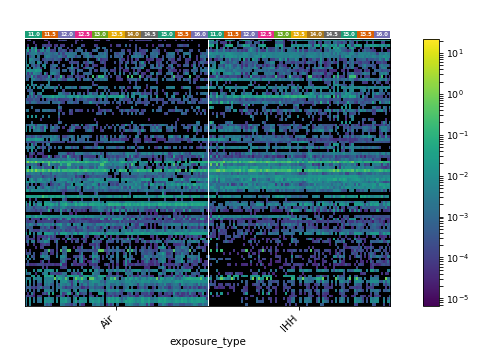

In [9]:
f=dexp.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5})

## Looking only at known metabolites
As a lot of differentially abundant metabolites are not identified, one might be interested in looking at just the identified features to begin with.

To do this, we filter the features (axis='f') based on the field 'gnps_name' (which contains the gnps derived name for the metabolite or nan if not found in gnps), and use select=None to remove the nan sample.

** Note ** This only works if you supply the gnps cluster info file (gnps_file) when calling read_ms()

In [10]:
# filter features without IDs
expcff = expcf.filter_by_metadata(field='gnps_name', select=None, axis='f')

In [11]:
print('There are %d identified features in the experiment' %expcff.shape[1])

There are 653 identified features in the experiment


### Differential abundance only on the identified metabolites

In [12]:
dexp = expcff.diff_abundance(field = 'exposure_type', val1='Air', val2='IHH', random_seed=2018, 
                             transform='binarydata')

2019-04-18 14:20:52 INFO 176 samples with both values
2019-04-18 14:20:52 INFO After filtering, 650 remaining
2019-04-18 14:20:52 INFO 88 samples with value 1 (['Air'])
2019-04-18 14:20:52 INFO number of higher in Air: 22. number of higher in IHH : 16. total 38


<IPython.core.display.Javascript object>


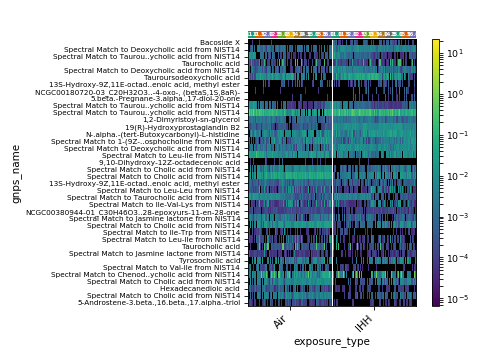

In [13]:
# plotting identified differentially abundant features
f = dexp.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5}, 
         feature_field='gnps_name', yticklabel_kwargs={'size':7,'rotation': 0}, yticklabel_len=50, 
           yticks_max=None)

### The metabolites higher in each group
Since the names are long, hard to fully read in the graph. So let's print the full name of each metabolite

#### IHH

In [14]:
print(dexp.feature_metadata.gnps_name[dexp.feature_metadata._calour_direction=='IHH'].values)

['Bacoside X' 'Spectral Match to Deoxycholic acid from NIST14'
 'Spectral Match to Tauroursodeoxycholic acid from NIST14'
 'Taurocholic acid' 'Spectral Match to Deoxycholic acid from NIST14'
 'Tauroursodeoxycholic acid'
 '13S-Hydroxy-9Z,11E-octadecadienoic acid, methyl ester'
 'NCGC00180720-03_C20H32O3_1-Naphthalenepentanoic acid, 1,4,4a,5,6,7,8,8a-octahydro-beta,2,5,5,8a-pentamethyl-4-oxo-, (betaS,1S,8aR)-'
 '5.beta.-Pregnane-3.alpha.,17-diol-20-one'
 'Spectral Match to Tauroursodeoxycholic acid from NIST14'
 'Spectral Match to Tauroursodeoxycholic acid from NIST14'
 '1,2-Dimyristoyl-sn-glycerol' '19(R)-Hydroxyprostaglandin B2'
 'N-.alpha.-(tert-Butoxycarbonyl)-L-histidine'
 'Spectral Match to 1-(9Z-Octadecenoyl)-sn-glycero-3-phosphocholine from NIST14'
 'Spectral Match to Deoxycholic acid from NIST14']


#### Air

In [15]:
print(dexp.feature_metadata.gnps_name[dexp.feature_metadata._calour_direction=='Air'].values)

['Spectral Match to Leu-Ile from NIST14'
 '9,10-Dihydroxy-12Z-octadecenoic acid'
 'Spectral Match to Cholic acid from NIST14'
 'Spectral Match to Cholic acid from NIST14'
 '13S-Hydroxy-9Z,11E-octadecadienoic acid, methyl ester'
 'Spectral Match to Leu-Leu from NIST14'
 'Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to Ile-Val-Lys from NIST14'
 'NCGC00380944-01_C30H46O3_(3beta,5xi,9xi,13alpha,17alpha,18xi)-3-Hydroxy-13,28-epoxyurs-11-en-28-one'
 'Spectral Match to Jasmine lactone from NIST14'
 'Spectral Match to Cholic acid from NIST14'
 'Spectral Match to Ile-Trp from NIST14'
 'Spectral Match to Leu-Ile from NIST14' 'Taurocholic acid'
 'Spectral Match to Jasmine lactone from NIST14' 'Tyrosocholic acid'
 'Spectral Match to Val-Ile from NIST14'
 'Spectral Match to Chenodeoxycholic acid from NIST14'
 'Spectral Match to Cholic acid from NIST14' 'Hexadecanedioic acid'
 'Spectral Match to Cholic acid from NIST14'
 '5-Androstene-3.beta.,16.beta.,17.alpha.-triol']


**Observation 2.** We observed that this list of differentially abundant metabolites is enriched in **bile acids** (cholic acid, taurocholic acid, chenodeoxycholic acid, tauroursocholic acid etc.) and **hormones** (5-Androstene-3.beta.,16.beta.,17.alpha.-triol, 5.beta.-Pregnane-3.alpha.,17-diol-20-one) among other molecules. Looking at this, we can begin to hypothesize the possible pathways disrupted in the microbiome, (and hence the host) due to IHH. In this case, it appears that the downstream effects of IHH could be linked to alterations in bile acid pool and endocrine disruption. 

Although we must note that these are spectral aligment based annotations (level 2 annotations) according to metabolomics reporting standards (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3772505/) and should be confirmed by comparision with pure analytical standards (level 1 annotation). 

## Differentially abundant metabolites between baseline samples (age=10 weeks) and the rest
This is most likely due to the shift to high fat diet after the 10 weeks samples

In [16]:
# just keep named metabolites
expff = exp.filter_by_metadata(field='gnps_name', select=None, axis='f')

In [17]:
dexp = expff.diff_abundance('age', val1=['10'], transform='binarydata', random_seed=2018)

2019-04-18 14:21:17 INFO After filtering, 653 remaining
2019-04-18 14:21:17 INFO 16 samples with value 1 (['10'])
2019-04-18 14:21:17 INFO number of higher in 10: 48. number of higher in NOT 10 : 164. total 212


<IPython.core.display.Javascript object>


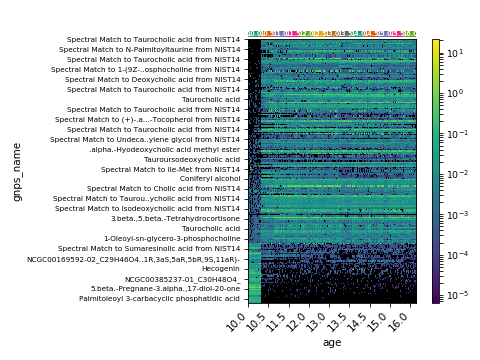

In [18]:
dexp = dexp.sort_samples('age')
f = dexp.plot(sample_field='age',barx_fields=['age'], feature_field='gnps_name', gui='jupyter', 
          yticklabel_kwargs={'rotation':0, 'size':7}, yticklabel_len=50)

### Metabolites higher in normal diet (10 weeks group)

In [19]:
print(dexp.feature_metadata.gnps_name[dexp.feature_metadata._calour_direction=='10'].values)

['Spectral Match to Chenodeoxycholic acid from NIST14'
 'Ethyldiethanolamine' 'NCGC00385237-01_C30H48O4_'
 '4-Hydroxy-17.beta.-estradiol'
 'Spectral Match to Sumaresinolic acid from NIST14' 'Tyrosocholic acid'
 'Hexadecanedioic acid' 'Spectral Match to Leu-Val-Lys from NIST14'
 '1H-Indole-3-carboxylic acid, 1-(5-hydroxypentyl)-, 8-quinolinyl ester'
 'Spectral Match to Leu-Val-Lys from NIST14'
 'Spectral Match to Coproporphyrin III from NIST14'
 "1-Oleoyl-2-hydroxy-sn-glycero-3-phospho-(1'-rac-glycerol)"
 'NCGC00169592-02_C29H46O4_3aH-Cyclopenta[a]chrysene-3a-carboxylic acid, 1-acetyleicosahydro-9-hydroxy-5a,5b,8,8,11a-pentamethyl-, (1R,3aS,5aR,5bR,9S,11aR)-'
 '5-Androstene-3.beta.,16.beta.,17.alpha.-triol' '2,3-Dehydrosilybin B'
 'Spectral Match to Val-Ile from NIST14'
 '1-Hexadecanoyl-2-sn-glycero-3-phosphate' 'NCGC00385237-01_C30H48O4_'
 'Sophoricoside' 'NCGC00385237-01_C30H48O4_' 'Hecogenin'
 'Spectral Match to Val-Leu from NIST14'
 'Spectral Match to Sebacic acid monomethyl ester f

### Metabolites higher in high fat diet (>10 weeks group)

In [20]:
print(dexp.feature_metadata.gnps_name[dexp.feature_metadata._calour_direction=='NOT 10'].values)

['Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to Deoxycholic acid from NIST14'
 '1-Palmitoyl-sn-glycero-3-phosphocholine'
 'Spectral Match to Lyso-PC(16:0) from NIST14' 'Taurocholic acid'
 'Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to N-Palmitoyltaurine from NIST14' 'Coniferyl alcohol'
 'Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to Tauroursodeoxycholic acid from NIST14'
 'Cortisol 21-sulfate'
 'Spectral Match to 1-(9Z-Octadecenoyl)-sn-glycero-3-phosphocholine from NIST14'
 'Spectral Match to 1-Myristoyl-sn-glycero-3-phosphocholine from NIST14'
 'Spectral Match to 1-Octadecanoyl-sn-glycero-3-phosphocholine from NIST14'
 'Spectral Match to Taurocholic acid from NIST14'
 'Spectral Match to Deoxycholic acid from NIST14' 'Taurocholic acid'
 'Spectral Match to Cholic acid from NIST14' 'Taurocholic acid'
 'Isoleucocholic acid' '

**Observation 3.** Looking at the heatmap and these lists, we can quickly see that as mice are switched to a high-fat diet, there is an large increase in bile acids in the gut metabolome, both host-derived (eg. Taurocholic acid, Cholic acid ) and microbe-derived (eg. Deoxycholic acid, Tauroursodeoxycholic acid, 12-Ketodeoxycholic acid). Similar results have been observed in other studies as well [26595891,29173647]. Here, we are able to verify previosly observed trends in very easy steps!

## Looking at gnps components
each gnps component include metabolites that are related to each other. We can sort the metabolites based on their component in order to reduce noise and gain more meaning

### Sorting by the cluster index
This way we can examine if clusters of metabolites in the molecular network. 
In addition to being an easier alternative to look at molecular networking data ( as opposed to rendering it as a network in cytoscape & overlaying metadata), this also helps us query temporal trends in data to observe trends in molecules belonging to the same cluster across samples and along time. 

<IPython.core.display.Javascript object>


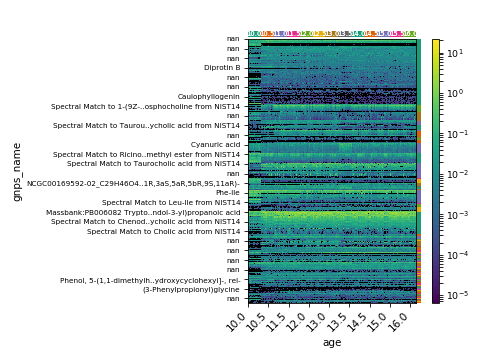

In [21]:
# sorting by cluster index
exps = exp.sort_by_metadata('gnps_component', axis='f')
exps = exps.sort_samples('age')
exps.plot(sample_field='age',barx_fields=['age'],feature_field='gnps_name', gui='jupyter', 
          yticklabel_kwargs={'rotation':0, 'size':7}, yticklabel_len=50, bary_fields=['gnps_component'],
         bary_label=False)

### Merging all metabolites in each cluster
We create a single "super-metabolite" for each cluster, containing the sum of frequencies of all metabolites in the cluster.

<IPython.core.display.Javascript object>


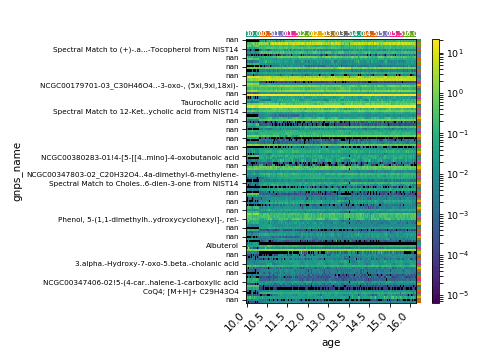

In [22]:
expsagg =exps.aggregate_by_metadata('gnps_component', agg='sum', axis='f')
expsagg.plot(sample_field='age',barx_fields=['age'], feature_field='gnps_name', gui='jupyter', 
          yticklabel_kwargs={'rotation':0, 'size':7}, yticklabel_len=50, bary_fields=['gnps_component'],
         bary_label=False)

### A code snipplet to add all gnps ids to each merged cluster
They are added to a new feature_metadata field called "gnps_all"

In [23]:
import numpy as np
o = []
for cm in expsagg.feature_metadata._calour_merge_ids:
    resstr=''
    for cid in cm.split(';'):
        cid = int(cid)
        cname = exps.feature_metadata.gnps_name.loc[cid]
        if cname=='nan':
            continue
        if isinstance(cname,float):
            continue
        resstr += cname+';'
    if resstr=='':
        resstr='na'
    o.append(resstr)
expsagg.feature_metadata['gnps_all'] = o

### Now we can do this differential abundance analysis on these super-metabolites

In [24]:
dexp = expsagg.diff_abundance('age', val1=['10'], transform='binarydata', random_seed=2018)

2019-04-18 14:21:53 INFO After filtering, 118 remaining
2019-04-18 14:21:53 INFO 16 samples with value 1 (['10'])
2019-04-18 14:21:53 INFO number of higher in 10: 6. number of higher in NOT 10 : 34. total 40


<IPython.core.display.Javascript object>


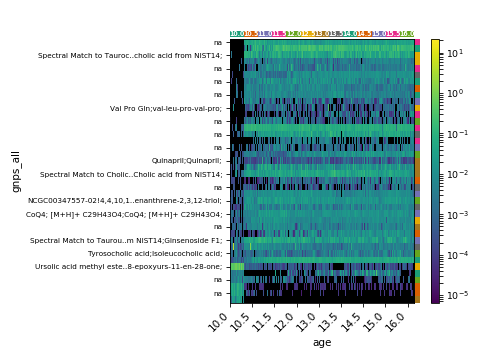

In [25]:
dexp.plot(sample_field='age',barx_fields=['age'], feature_field='gnps_all', gui='jupyter', 
          yticklabel_kwargs={'rotation':0, 'size':7}, yticklabel_len=50, bary_fields=['gnps_component'],
         bary_label=False)

## Looking for metabolite artifacts
### (split features due to RT/MZ tolerances during feature finding)
Sometimes feature finding is not perfect, and we get several metabolites with very close mz/rt.

In order to identify these occurances, we sort the features by the MZ and then plot the heatmap and look for neighboring metabolites that behave very similar and have close MZ/RT

<IPython.core.display.Javascript object>


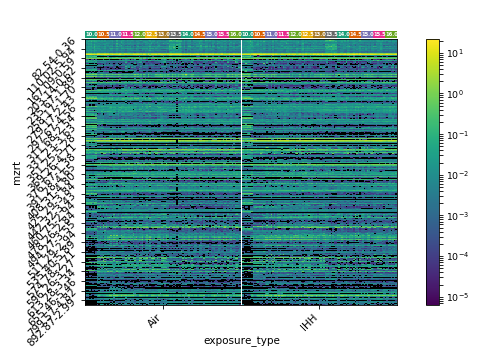

In [26]:
expart = exp.sort_samples(field='age').sort_samples(field='exposure_type')
expart =expart.sort_by_metadata(field='MZ',axis='f')

#adding new column 'mzrt' to feature metadata
expart.feature_metadata['mzrt'] = expart.feature_metadata.MZ.map("{0:.2f}".format) + '-' + expart.feature_metadata.RT.map("{0:.2f}".format)

f = expart.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5},
               feature_field='mzrt')

### Similar mz and RT and same trend across samples
Here are some examples we found when interactively looking at the heatmap.

We get the rect coordinates by pressing the "print axes ranges" button when we get a view containing the suspect features.

This way we can reporoduce the zoomed figure inside the notebook

<IPython.core.display.Javascript object>


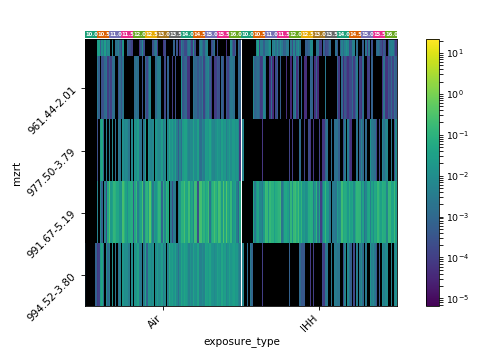

In [27]:
f = expart.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5},
               rect=[-0.5, 207.5, 1098.5, 1094.20703125], feature_field='mzrt')

**Observation 4a.** They have MZ of 994.5221123 and 977.4951502999999 and RT of 228.17 and 227.38. They could be NH4 adducts of the same ion (http://fiehnlab.ucdavis.edu/staff/kind/Metabolomics/MS-Adduct-Calculator)

###  Identical m/z and very close RT

<IPython.core.display.Javascript object>


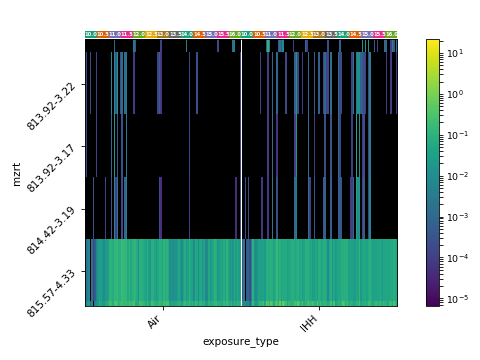

In [28]:
f = expart.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5},
               rect=[-0.5, 207.5, 1055.5703125, 1051.27734375],feature_field='mzrt')

<IPython.core.display.Javascript object>


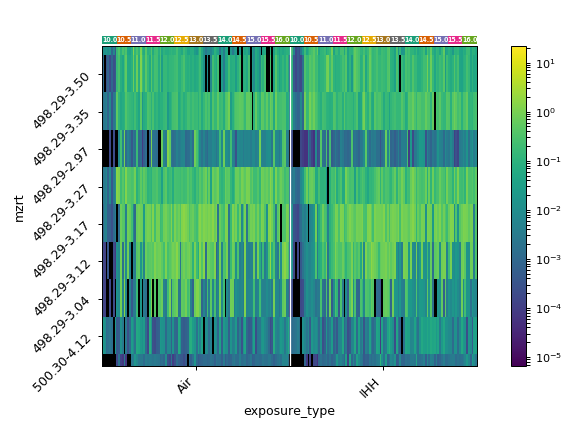

In [31]:
f = expart.plot(sample_field='exposure_type', gui='jupyter', barx_fields=['age'], barx_label_kwargs={'size':5},
               rect=[-0.5, 207.5, 780.8203125, 772.234375],feature_field='mzrt')

**Observation 4b.** These could be isomers or artefacts of feature detection where the same feature got split into multiple features due to strong RT drift in some samples, broad peak shape etc. These cases would need further investigation in MZmine2.

**Conclusion**
In this notebook, we obtained insights on how intermittent hypoxia and hypercapnia (IHH) could be perturning the host-commensal metabolism. We also confirmed previous findings on the effect of high-fat diet on gut metabolome. Additionally, we were able to QC feature finding on these data and identified the possibility of adducts, isomers or split features in these data. All this could be done by following some easy steps in calour in a single Jupyter notebook (as opposed to using different software packages for each task, re-formatting data for each platform and so on)